# Project Step 1
Project group: Leo Winter, Yoann Sublet, Kellian VERVAELE--KLEIN

1. Descriptive analysis of your data.
2. Implementation of the necessary pre-processing.
3. Formalisation of the problem.
4. Selection of a baseline model and implementation of the model.

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# 1) Descriptive analysis of the Credit Card Fraud Dataset

### 1. Informations on the dataset

Dataset description (from Kaggle):
* The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
* It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, the original features and background information about the data cannot be provided. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Explanation of each known feature:
- V1 to V28: anonymized features obtained through PCA transformation
- Time: Seconds elapsed between this transaction and the first transaction in the dataset
- Amount: Transaction amount
- Class: target variable, either 1 (fraud) or 0 (legitimate)

In [ ]:
df = pd.read_csv("creditcard.csv", sep=",")
print(df.head())

In [ ]:
print(f"\nDataset Shape: {df.shape}")
print(f"Number of Rows: {df.shape[0]:,}")
print(f"Number of Columns: {df.shape[1]}")

- 284 807 entries, without no missing data (0 NaN or null rows)
- Data types: float64 for all features a part for the class which is int64 since its binary (either 0 or 1)

In [ ]:
df.info()

#### Statistical summary:

In [ ]:
df.describe()

### 2. Visualizations of the Dataset

Visualization of V1 and V2 over Time with amount

In [ ]:
fig1 = px.scatter(df, x="V1", y="V2", size="Amount", color=df["Class"].astype(str),
                   color_discrete_map={'1': "red", '0': "green"},
                   title="Repartition of transactions in function of V1 and V2")
fig1.update_traces(marker=dict(showscale=False))
fig1.update_layout(legend_title_text="Transaction type")
fig1.show()

In [ ]:
fig2 = px.scatter(df[df["Class"]==1], x="V1", y="V2", size="Amount", color="Class",
                  title="Repartition of fraud transactions in function of V1 and V2")
fig2.update_traces(marker=dict(showscale=False))
fig2.show()

In [ ]:
df_fig3 = df[(df["V2"]>-10) & (df["V1"]>-31)]
fig3 = px.scatter(df_fig3, x="V1", y="V2", size="Amount", color=df_fig3["Class"].astype(str),
                  color_discrete_map={'1': "red", '0': "green"},
                  title="Zoomed repartition of transactions in function of V1 and V2")
fig3.update_traces(marker=dict(showscale=False))
fig3.update_layout(legend_title_text="Transaction type")
fig3.show()

# 2) Data Preprocessing

#### Checking for duplicates and dropping them if any

In [ ]:
df_processed = df.copy()
# Check for duplicates
duplicates = df_processed.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

if duplicates > 0:
    df_processed = df_processed.drop_duplicates()
    print(f"New Dataset shape: {df_processed.shape}")
else:
    print("No duplicates")

#### Separation of features and target

In [ ]:
X = df_processed.drop("Class", axis=1)
y = df_processed["Class"]

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

#### Scaling with StandardScaler: only for the features Time and Amount.
Features V1 to V28 are already scaled (PCA transformed)

In [ ]:
scaler = StandardScaler()

In [ ]:
# Scaling of Time and Amount features using the StandardScaler
X['Time_scaled'] = scaler.fit_transform(X[['Time']])
X['Amount_scaled'] = scaler.fit_transform(X[['Amount']])

In [ ]:
# Drop original Time and Amount columns
X = X.drop(['Time', 'Amount'], axis=1)

In [ ]:
print(X[['Time_scaled', 'Amount_scaled']].describe())

#### Splitting the dataset into train and test sets
We use the stratify parameter of train_test_split to balance the target since our dataset is very imbalanced.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]:,} samples")
print(f"Testing set size: {X_test.shape[0]:,} samples")

# 3) Problem Formalization

In this section, we formally define the machine learning problem, our target, the metrics we will use to measure success, and any constraints we need to consider.

#### 3.1. Type of Problem

This is a binary classification problem.  
For every transaction given as input, our model must decide which of two possible categories it belongs to:

- Class 0: Normal (a legitimate transaction)  
- Class 1: Fraud (a fraudulent transaction)

The output of our model will be a prediction of either 0 or 1.

#### 3.2. Target Variable

The target variable that we are trying to predict is the Class column in the dataset.

#### 3.3. Evaluation Metrics

This is the most critical part of our problem formalization.  
The dataset is severely imbalanced, with "Fraud" (Class 1) transactions representing only about 0.172% of the total.

Because of this, Accuracy is a useless metric.  

##### Confusion Matrix

|                      | Predicted Fraud (1) | Predicted Normal (0) |
|----------------------|--------------------------|---------------------------|
| Actual Fraud (1) | True Positive (TP)     | False Negative (FN)     |
| Actual Normal (0)| False Positive (FP)    | True Negative (TN)      |

- True Positives (TP): The model predicts "Fraud," and it is a "Fraud."
- True Negatives (TN): The model predicts "Normal," and it is "Normal."
- False Positives (FP): The model predicts "Fraud," but it was "Normal."
- False Negatives (FN): The model predicts "Normal," but it was a "Fraud."


##### Recall

Recall = TP/(TP + FN)

This is our most important metric.  
We want to maximize this, as False Negatives are the most costly error.

##### Precision

Precision = TP/(TP + FP)

If precision is low, we generate too many False Positives.

##### F1-Score

F1 = (2 * Precision * Recall) / (Precision + Recall)

It provides a single score that balances precision and recall, which is useful for comparing models.

##### Area Under the Precision-Recall Curve (AUC-PR)

Unlike the standard AUC-ROC, the AUC-PR is much more informative on heavily imbalanced datasets.  
It provides a summary of the model's performance across all possible decision thresholds, focusing on the trade-off between Precision and Recall.

#### 3.4. Constraints

- Cost of Errors:
  The cost is asymmetric.  
  A False Negative (FN) (missing a fraud) has a direct and high financial cost.  
  A False Positive (FP) (flagging a normal transaction) has a lower, but non-zero, operational cost (customer support, user friction).  
  Our model must prioritize minimizing FNs (maximizing Recall).

- Interpretability:
  For regulatory and diagnostic purposes, it's highly desirable to understand why a model flagged a transaction as fraudulent.  
  This suggests that "black box" models might be less ideal than simpler, interpretable models.


# 4) Implementation of a baseline model

We create a Decision Tree with the DecisionTreeClassifier class from Scikit-learn using a random state of 42 and applying the class_weight parameter to 'balanced' since our dataset is heavily unbalanced.

From the Scikit-learn documentation: The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

In [ ]:
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)

In [36]:
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

from collections import Counter
print(f"Number of predictions of class 0: {Counter(y_pred_dt)[np.int64(0)]}")
print(f"Number of predictions of class 1: {Counter(y_pred_dt)[np.int64(1)]}")

Number of predictions of class 0: 56664
Number of predictions of class 1: 82


In [37]:
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

print(f"\nAccuracy:  {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall:    {recall_dt:.4f}")
print(f"F1-Score:  {f1_dt:.4f}")
print(f"AUC-ROC:   {auc_dt:.4f}")


Accuracy:  0.9990
Precision: 0.7317
Recall:    0.6316
F1-Score:  0.6780
AUC-ROC:   0.8156


In [39]:
print(classification_report(y_test, y_pred_dt, target_names=['Legitimate', 'Fraud']))

              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56651
       Fraud       0.73      0.63      0.68        95

    accuracy                           1.00     56746
   macro avg       0.87      0.82      0.84     56746
weighted avg       1.00      1.00      1.00     56746



In [42]:
cm_dt = confusion_matrix(y_test, y_pred_dt)
print(cm_dt)
print(f"\nTrue Negatives:  {cm_dt[0,0]:,}")
print(f"False Positives: {cm_dt[0,1]:,}")
print(f"False Negatives: {cm_dt[1,0]:,}")
print(f"True Positives:  {cm_dt[1,1]:,}")

[[56629    22]
 [   35    60]]

True Negatives:  56,629
False Positives: 22
False Negatives: 35
True Positives:  60


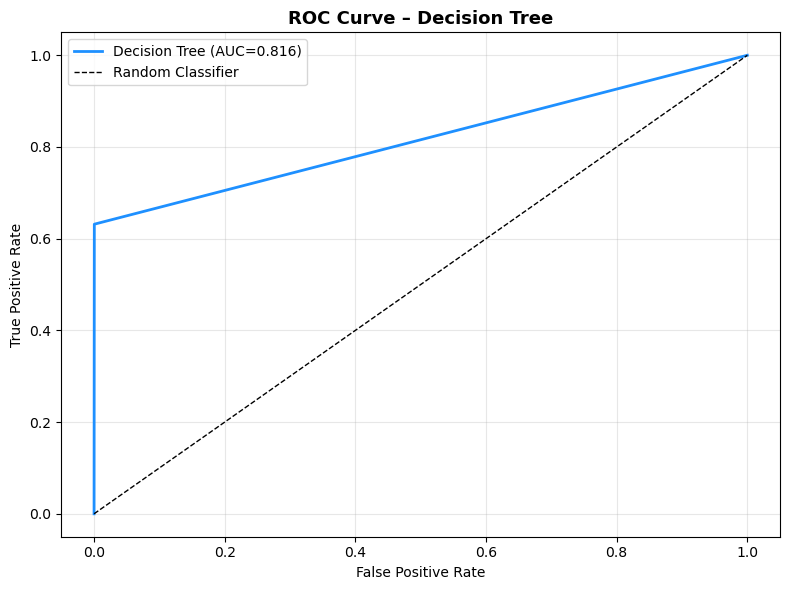

In [53]:
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
auc_dt = auc(fpr_dt, tpr_dt)
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='dodgerblue', linewidth=2,
         label=f'Decision Tree (AUC={auc_dt:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

# Labels, title, and style
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Decision Tree', fontweight='bold', fontsize=13)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()